<a href="https://colab.research.google.com/github/rtealwitter/dl-demos/blob/main/demo09-rl-basics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Reinforcement Learning Basics

In this demo, we will play around with the environments available through [Gym](https://www.gymlibrary.dev/).

## Libraries

For visualizing our agent playing, we'll need to load the following library.

In [1]:
!pip3 install imageio==2.4.1
!pip3 install gym[classic_control]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 20.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for imageio: filename=imageio-2.4.1-py3-none-any.whl size=3303886 sha256=214b54b5214c139bd8badc0979aebd2755c53ad64266846ef23f9c40244fef32
  Stored in directory: /root/.cache/pip/wheels/be/7b/04/4d8d56f1d503e5c404f0de6018c0cfa592c71588a39b49e002
Successfully built imageio
  Attempting uninstall: imageio
    Found existing installation: imageio 2.9.0
    Uninstalling imageio-2.9.0:
      Successfully uninstalled imageio-2.9.0
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 8.4 MB/s eta 0:00:00


In [2]:
# Libraries
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.distributions as distributions
import matplotlib.pyplot as plt
import numpy as np
import gym

import moviepy.video.io.ImageSequenceClip
from moviepy.editor import *

Imageio: 'ffmpeg-linux64-v3.3.1' was not found on your computer; downloading it now.
Try 1. Download from https://github.com/imageio/imageio-binaries/raw/master/ffmpeg/ffmpeg-linux64-v3.3.1 (43.8 MB)
Downloading: 8192/45929032 bytes (0.0%)1433600/45929032 bytes (3.1%)3973120/45929032 bytes (8.7%)6316032/45929032 bytes (13.8%)7897088/45929032 bytes (17.2%)10362880/45929032 bytes (22.6%)12877824/45929032 bytes (28.0%)15376384/45929032 bytes (33.5%)18227200/45929032 bytes (39.7%)21192704/45929032 bytes (46.1%)23142400/45929032 bytes (50.4%)25231360/45929032 bytes (54.9%)27336704/45929032 bytes (59.5%)290

Check out a list of classic games [here](https://www.gymlibrary.dev/environments/classic_control/). We'll be experimenting with Cart Pole where the object is to keep a pole on top of a cart without falling.

In [3]:
env = gym.make('CartPole-v1')

  deprecation(

  deprecation(



The observation space consits of four variables:

* Cart position (on a line)

* Cart velocity

* Pole angle

* Pole angular velocity


In [4]:
print(env.observation_space)
print(env.observation_space.shape)

Box([-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38], [4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38], (4,), float32)
(4,)


We can take two actions: either push the cart to the left or to the right.

In [5]:
print(env.action_space)

Discrete(2)


The game is actually pretty hard! You can try your hand at it [here](https://jeffjar.me/cartpole.html). Now let's train a policy to beat it. We start by loading two different copies of the environment; one for training and one for testing.

In [6]:
train_env = gym.make('CartPole-v1')
test_env = gym.make('CartPole-v1')

We'll train a neural network that is actually incredibly simple: only two layers with dropout and ReLU.

In [7]:
class PolicyNet(nn.Module):
  def __init__(self, input_dim, hidden_dim, output_dim, dropout=.5):
    super().__init__()
    self.net = nn.Sequential(
        nn.Linear(input_dim, hidden_dim),
        nn.Dropout(dropout),
        nn.ReLU(),
        nn.Linear(hidden_dim, output_dim)
    )

  def forward(self, x):
    return self.net(x)

As we've done many times before, we initialize our architecture and optimizer. However, the loss will be slightly more tricky to compute than normal.

In [8]:
input_dim = train_env.observation_space.shape[0]
print('input dim:', input_dim)

output_dim = train_env.action_space.n
print('output dim:', output_dim)

hidden_dim = 128

policy = PolicyNet(input_dim, hidden_dim, output_dim)
print(policy)

optimizer = optim.Adam(policy.parameters(), lr=0.01)

input dim: 4
output dim: 2
PolicyNet(
  (net): Sequential(
    (0): Linear(in_features=4, out_features=128, bias=True)
    (1): Dropout(p=0.5, inplace=False)
    (2): ReLU()
    (3): Linear(in_features=128, out_features=2, bias=True)
  )
)


In class, we described how to compute a single discounted reward of a trajectory. In practice, we want to leverage our data for more updates. We do this by considering the future discounted reward for *every* state in our trajectory.

In [9]:
def calculate_returns(rewards, discount_factor, normalize=True):
  returns = []
  R = 0
  # Clever method for computing the future discounted reward
  for r in reversed(rewards): 
    R = r + R * discount_factor
    returns.insert(0,R)

  returns = torch.tensor(returns)
  # Remember we normalize to differentiate between
  # "good" and "bad" actions
  if normalize:
    returns = (returns - returns.mean()) / returns.std()
  
  return returns

Once we have returns and log probabilities of the actions we take, we will compute the loss and optimize.

In [10]:
def update_policy(returns, log_prob_actions, optimizer):
  returns = returns.detach()
  # Because we minimize (by convention) and we actually
  # want to maximize returns, we negate the expected sum
  loss = - (returns * log_prob_actions).sum()
  optimizer.zero_grad()

  loss.backward()
  optimizer.step()

  return loss.item()

Now we write the training and evaluation functions. Notice how training in RL is more involved than our standard applications.

In [11]:
def train(env, policy, optimizer, discount_factor=.99):
  policy.train()
  
  log_prob_actions = []
  rewards = []
  done = False
  episode_reward = 0

  state = env.reset()

  while not done:
    state = torch.FloatTensor(state).unsqueeze(0)
    action_pred = policy(state)
    action_prob = F.softmax(action_pred, dim = -1)

    dist = distributions.Categorical(action_prob)
    action = dist.sample() # we sample (rather than take the best)
    log_prob_action = dist.log_prob(action)

    state, reward, done, _ = env.step(action.item())

    log_prob_actions.append(log_prob_action)
    rewards.append(reward)

    episode_reward += reward
  
  log_prob_actions = torch.cat(log_prob_actions)
  returns = calculate_returns(rewards, discount_factor)
  loss = update_policy(returns, log_prob_actions, optimizer)

  return loss, episode_reward


In [12]:
def evaluate(env, policy, return_frames=False):
  policy.eval()

  done = False
  episode_reward = 0
  state = env.reset()
  frames = []

  while not done:
    if return_frames:
      frames += [env.render(mode='rgb_array')]
    state = torch.FloatTensor(state).unsqueeze(0)

    action_pred = policy(state)
    action_prob = F.softmax(action_pred, dim=-1)

    action = torch.argmax(action_prob, dim=-1) # we take the best
    state, reward, done, _ = env.step(action.item())
    episode_reward += reward
  
  if return_frames:
    return episode_reward, frames
  return episode_reward

Now we're ready to train. Notice the very jagged nature of the loss history. This is because RL is different from our regular training: our policy is stochastic and the reward is more "sparse".

In [13]:
max_episodes = 500
num_trials = 25
reward_threshold = 475
print_every = 10

train_rewards = []
test_rewards = []

for episode in range(1, max_episodes+1):
  loss, train_reward = train(train_env, policy, optimizer)
  test_reward = evaluate(test_env, policy)

  train_rewards += [train_reward]
  test_rewards += [test_reward]

  mean_train_rewards = np.mean(train_rewards[-num_trials:])
  mean_test_rewards = np.mean(test_rewards[-num_trials:])

  if episode % print_every == 0:    
    print(f'| Episode: {episode:3} | Mean Train Rewards: {mean_train_rewards:5.1f} | Mean Test Rewards: {mean_test_rewards:5.1f} |')
    
  if mean_test_rewards >= reward_threshold:
    print(f'Reached reward threshold in {episode} episodes')
    break


| Episode:  10 | Mean Train Rewards:  22.9 | Mean Test Rewards:  39.7 |
| Episode:  20 | Mean Train Rewards:  34.9 | Mean Test Rewards:  80.3 |
| Episode:  30 | Mean Train Rewards:  49.6 | Mean Test Rewards:  99.8 |
| Episode:  40 | Mean Train Rewards:  51.9 | Mean Test Rewards:  82.9 |
| Episode:  50 | Mean Train Rewards:  38.0 | Mean Test Rewards:  39.8 |
| Episode:  60 | Mean Train Rewards:  29.0 | Mean Test Rewards:  28.1 |
| Episode:  70 | Mean Train Rewards:  30.2 | Mean Test Rewards:  30.0 |
| Episode:  80 | Mean Train Rewards:  47.1 | Mean Test Rewards:  54.0 |
| Episode:  90 | Mean Train Rewards:  71.0 | Mean Test Rewards:  76.0 |
| Episode: 100 | Mean Train Rewards:  87.9 | Mean Test Rewards: 121.8 |
| Episode: 110 | Mean Train Rewards:  75.5 | Mean Test Rewards: 133.6 |
| Episode: 120 | Mean Train Rewards:  83.0 | Mean Test Rewards: 122.1 |
| Episode: 130 | Mean Train Rewards:  99.2 | Mean Test Rewards:  94.2 |
| Episode: 140 | Mean Train Rewards:  84.0 | Mean Test Rewards: 

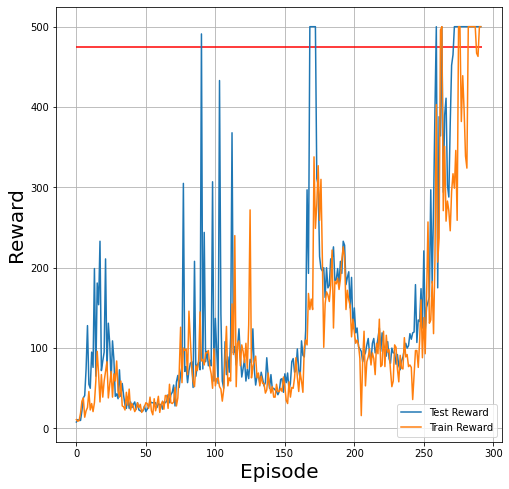

In [14]:
plt.figure(figsize=(8,8))
plt.plot(test_rewards, label='Test Reward')
plt.plot(train_rewards, label='Train Reward')
plt.xlabel('Episode', fontsize=20)
plt.ylabel('Reward', fontsize=20)
plt.hlines(reward_threshold, 0, len(test_rewards), color='r')
plt.legend(loc='lower right')
plt.grid()

In [15]:
_, frames = evaluate(test_env, policy, return_frames = True)

See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(



In [16]:
clip = moviepy.video.io.ImageSequenceClip.ImageSequenceClip(frames, fps=50)
ipython_display(clip)

100%|██████████| 500/500 [00:02<00:00, 198.83it/s]
